# Initial

In [12]:
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image

DEVICE = "cuda"


import torch, random, numpy as np
from transformers import set_seed

def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(9)

from safetensors import safe_open

import matplotlib.pyplot as plt
import seaborn as sns

# Assign Prompts
All codes are for PyTorch side.

Run the following equivalent commands (select one) for the Kornia-rs side. (Activations are compared via the implicitly saved safetensor files.)
```sh
cargo run -p smol_vlm --features cuda -- -i .vscode/angela-porter-2021-jan-25.jpg -p "Can you describe the image?" --sample-length 500
cargo run -p smol_vlm --features cuda -- -p "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space." --sample-length 200
cargo run -p smol_vlm --features cuda -- -p "Can you describe the image?" --sample-length 500
cargo run -p smol_vlm --features cuda -- -p "What is life?" --sample-length 500
```

In [15]:
# image1 = load_image("https://media.istockphoto.com/id/485371557/photo/twilight-at-spirit-island.jpg?s=612x612&w=0&k=20&c=FSGliJ4EKFP70Yjpzso0HfRR4WwflC6GKfl4F3Hj7fk=")
# image2 = load_image("https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg")
# image1 = Image.open("../../../.vscode/fuji-mountain-in-autumn.jpg")
image1 = load_image("https://artwyrd.com/wp-content/uploads/2021/01/angela-porter-2021-jan-25.jpg")
print(f"Image 1 size: {image1.size}")


processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
messages = [
    {
        "role": "user",
        "content": [
            # {"type": "image"},
            # {"type": "text", "text": "Can you describe the image?"}
            # {"type": "text", "text": "What is life?"}
            {"type": "text", "text": "A real-valued function f defined on the real line is called an even function if f(-t) = f(t) for each real number t. Prove that the set of even functions defined on the real line with the operations of addition and scalar multiplication defined in Example 3 is a vector space."}
        ]
    },
]

Image 1 size: (900, 900)


# Activation introspection

In [16]:
from collections import OrderedDict
from activation_introspector import ActivationIntrospector

# Initialize model directly on CUDA without Flash Attention
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-Instruct",
    torch_dtype=torch.bfloat16,
    # _attn_implementation="flash_attention_2",  # Commented out Flash Attention
    device_map="cuda",
)
model.eval()

act_isp = ActivationIntrospector()
layers = OrderedDict()

layers["input_embeddings"] = model.get_input_embeddings()
for i in range(24):
    layers[f"input_layernorm_d{i}"] = model.model.text_model.layers[i].input_layernorm
    layers[f"self_attn_d{i}"]       = model.model.text_model.layers[i].self_attn
    layers[f"post_layernorm_d{i}"]  = model.model.text_model.layers[i].post_attention_layernorm
    #  layer[f"mlp_d{i}"]             = model.model.text_model.layers[i].mlp
    layers[f"mlp_gate_proj_d{i}"]   = model.model.text_model.layers[i].mlp.gate_proj
    layers[f"mlp_up_proj_d{i}"]     = model.model.text_model.layers[i].mlp.up_proj
    layers[f"mlp_down_proj_d{i}"]   = model.model.text_model.layers[i].mlp.down_proj
    layers[f"mlp_act_fn_d{i}"]      = model.model.text_model.layers[i].mlp.act_fn
    layers[f"layers_d{i}"]          = model.model.text_model.layers[i]
layers["logits"] = model.get_output_embeddings()

act_isp.set_introspector(layers)
type(model)

transformers.models.idefics3.modeling_idefics3.Idefics3ForConditionalGeneration

In [17]:
model

Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

# Generation

In [18]:
# Prepare inputs
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
# inputs = processor(text=prompt, images=[image1], return_tensors="pt")
inputs = processor(text=prompt, return_tensors="pt")
inputs = inputs.to("cuda")

print(inputs["input_ids"])
# Generate outputs
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=500,
        # repition_penalty=1.1,  # Apply repeat penalty
        output_scores=True,           # Return logits for each generated token
        return_dict_in_generate=True, # Return detailed output object
        do_sample=False,  # Use greedy decoding (highest logit)
    )

outputs.sequences[0]

tensor([[    1, 11126,    42,   330,  1345,    29, 34270,  1517,   275,  4355,
           335,   260,  1345,  1761,   314,  1217,   354,   908,  1517,   585,
           275, 10242,   100,    25,   446,   275,    24,   100,    25,   327,
           971,  1345,  1230,   252,    30,  1053,   307,   338,   260,   932,
           282,   908,  3691,  4355,   335,   260,  1345,  1761,   351,   260,
          4261,   282,  1706,   284, 26727, 17385,  4355,   281, 12066,   216,
            35,   314,   253,  8431,  1898,    30, 49154,   198,  9519,  9531,
            42]], device='cuda:0')


tensor([    1, 11126,    42,   330,  1345,    29, 34270,  1517,   275,  4355,
          335,   260,  1345,  1761,   314,  1217,   354,   908,  1517,   585,
          275, 10242,   100,    25,   446,   275,    24,   100,    25,   327,
          971,  1345,  1230,   252,    30,  1053,   307,   338,   260,   932,
          282,   908,  3691,  4355,   335,   260,  1345,  1761,   351,   260,
         4261,   282,  1706,   284, 26727, 17385,  4355,   281, 12066,   216,
           35,   314,   253,  8431,  1898,    30, 49154,   198,  9519,  9531,
           42,  1626,  6824,   338,   260,   932,   282,   908,  3691,  4355,
          335,   260,  1345,  1761,   351,   260,  4261,   282,  1706,   284,
        26727, 17385,  4355,   281, 12066,   216,    35,   314,   253,  8431,
         1898,    28,   392,   737,   288,  1138,   338,   357, 38475,   260,
         1695,  3849,    42,  1116,    33,    30, 47630,   656,  1706,    42,
         1068,   750,   827,   908,  3691,   275,   284,   310, 

In [6]:
processor.tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

'User: What is life?\nAssistant: Life is a complex and fascinating concept that has been the subject of philosophical, scientific, and spiritual inquiry for centuries. At its most basic level, life is the characteristic that distinguishes living organisms from inanimate objects and non-living matter. Living organisms are capable of growth, self-sustaining metabolism, reproduction, and response to the environment.\n\nFrom a scientific perspective, life is often defined by the presence of a biological cell, which is the basic unit of all living organisms. Cells are made up of various organelles and structures that work together to perform essential functions such as metabolism, growth, and reproduction.\n\nFrom a philosophical perspective, life is often associated with consciousness, self-awareness, and the ability to experience emotions and suffering. Some philosophers argue that life is a unique and precious gift that should be valued and protected, while others believe that life is a 

# Validation

In [19]:
calc_err = lambda rust, python: (
    torch.nn.functional.mse_loss(rust.squeeze(), python.squeeze()).item(),
    torch.nn.functional.l1_loss(rust.squeeze(), python.squeeze()).item()
)
top_err = lambda rust, python: (rust.argsort(descending=True)[0].item(), python.squeeze().argsort(descending=True)[0].item())
topK_logits = lambda rust, python: (rust.argsort(descending=True)[:15], python.squeeze().argsort(descending=True)[:15])

err_fmt = lambda mse, mae: f"(MSE:{mse:.8f}, MAE:{mae:.8f})"

In [21]:
with safe_open("../validation_data/rust_introspection.safetensors", framework="pt", device="cpu") as f:
    logits_output = act_isp.compare_rust_activations(
        range(200), f, top_err, subset=["logits"]
    )
    for i in range(200):
        top_logits_rust = logits_output[f"logits_i{i}"][0]
        top_logits_python = logits_output[f"logits_i{i}"][1]
        if top_logits_python != top_logits_rust:
            print(f"Mismatch at index {i}: Python top {top_logits_python}, Rust top {top_logits_rust}")
            ind_div = i
            break

    topK_logits_output = act_isp.compare_rust_activations(range(200), f, topK_logits, subset=["logits"])
    all_output = act_isp.compare_rust_activations(range(200), f, calc_err)
    for i in range(max(0,ind_div-3), ind_div+2):
        print(f"[{i:>3}] EMBEDS{err_fmt(*all_output[f"input_embeddings_i{i}"])}  LOGITS{err_fmt(*all_output[f"logits_i{i}"])} ")

        top_logits_rust = topK_logits_output[f"logits_i{i}"][0]
        top_logits_python = topK_logits_output[f"logits_i{i}"][1]
        rust_logits = f.get_tensor(f"logits_i{i}").squeeze().cpu()
        python_logits = act_isp.activations[f"logits_i{i}"].squeeze().cpu()

        print(f"[PYTHON] Logits: {[python_logits[i].item() for i in top_logits_python]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_python]}")
        print(f"         Tokens:", [i.item() for i in top_logits_python])
        print(f"[RUST] Logits: {[rust_logits[i].item() for i in top_logits_rust]}, Tokens: {[processor.tokenizer.decode([i]) for i in top_logits_rust]}")
        print(f"         Tokens:", [i.item() for i in top_logits_rust])


        # for layer_d in [0]:
        for layer_d in range(24):
            layer_fmt = lambda layer: err_fmt(*all_output[f"{layer}_d{layer_d}_i{i}"])

            print(f"    [INPUT LAYERNORM]   {layer_fmt("input_layernorm")}")
            print(f"    [SELF ATTN]         {layer_fmt("self_attn")}")
            print(f"    [POST LAYERNORM]    {layer_fmt("post_layernorm")}")
            # print(f"    [MLP]              {layer_fmt("mlp")}")
            print(f"        [MLP/GATE PROJ] {layer_fmt("mlp_gate_proj")}")
            print(f"        [MLP/ACT FN]    {layer_fmt("mlp_act_fn")}")
            print(f"        [MLP/UP PROJ]   {layer_fmt("mlp_up_proj")}")
            print(f"        [MLP/DOWN PROJ] {layer_fmt("mlp_down_proj")}")
            print(f"[LAYER {layer_d:>2}]        {layer_fmt("layers")}")

Mismatch at index 95: Python top 198, Rust top 35
[ 92] EMBEDS(MSE:0.00000000, MAE:0.00000000)  LOGITS(MSE:0.00229770, MAE:0.03771792) 
[PYTHON] Logits: [28.25, 18.5, 17.625, 17.375, 16.25, 15.3125, 14.6875, 14.6875, 14.5, 13.875, 13.4375, 13.375, 13.375, 13.3125, 13.0], Tokens: [' function', ' functions', ' f', 'function', ' fun', ' func', '.', ' Function', ' (', ' and', '\n', ' functional', ' operation', ' number', ' fn']
         Tokens: [1517, 3691, 275, 6607, 1037, 16689, 30, 11956, 365, 284, 198, 6603, 4953, 1230, 24526]
[RUST] Logits: [28.375, 18.625, 17.625, 17.5, 16.375, 15.375, 14.875, 14.6875, 14.5625, 13.9375, 13.5, 13.4375, 13.375, 13.375, 13.0625], Tokens: [' function', ' functions', ' f', 'function', ' fun', ' func', '.', ' Function', ' (', ' and', '\n', ' operation', ' number', ' functional', ' fn']
         Tokens: [1517, 3691, 275, 6607, 1037, 16689, 30, 11956, 365, 284, 198, 4953, 1230, 6603, 24526]
    [INPUT LAYERNORM]   (MSE:0.00000000, MAE:0.00000000)
    [SELF A

# Visualization

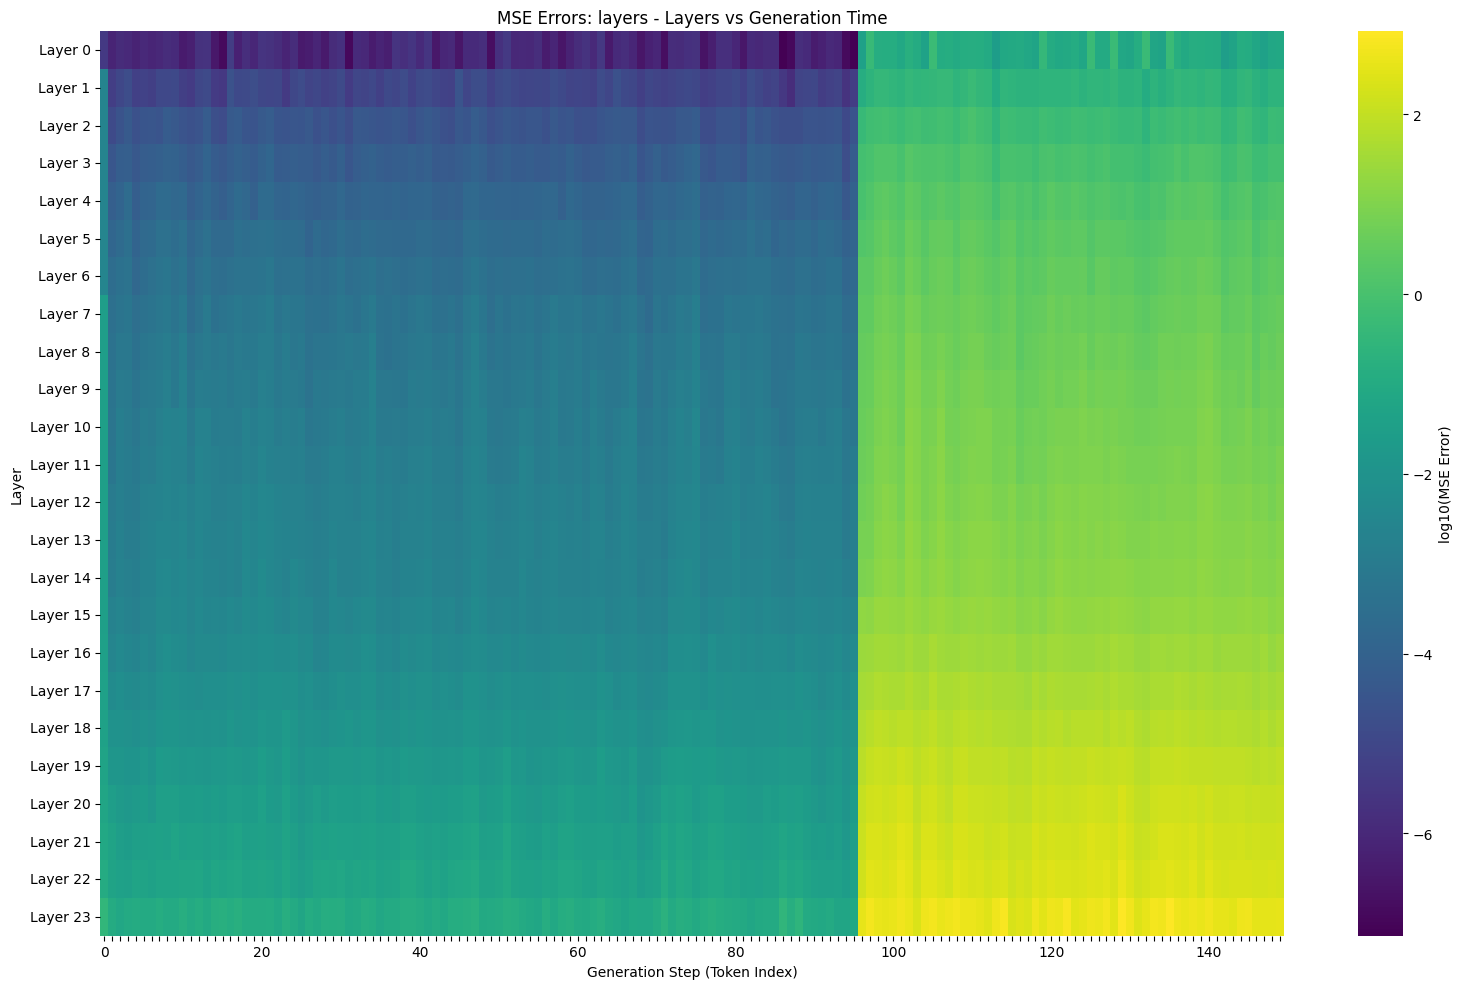

Global log10 error range: [-10.00, 2.92]


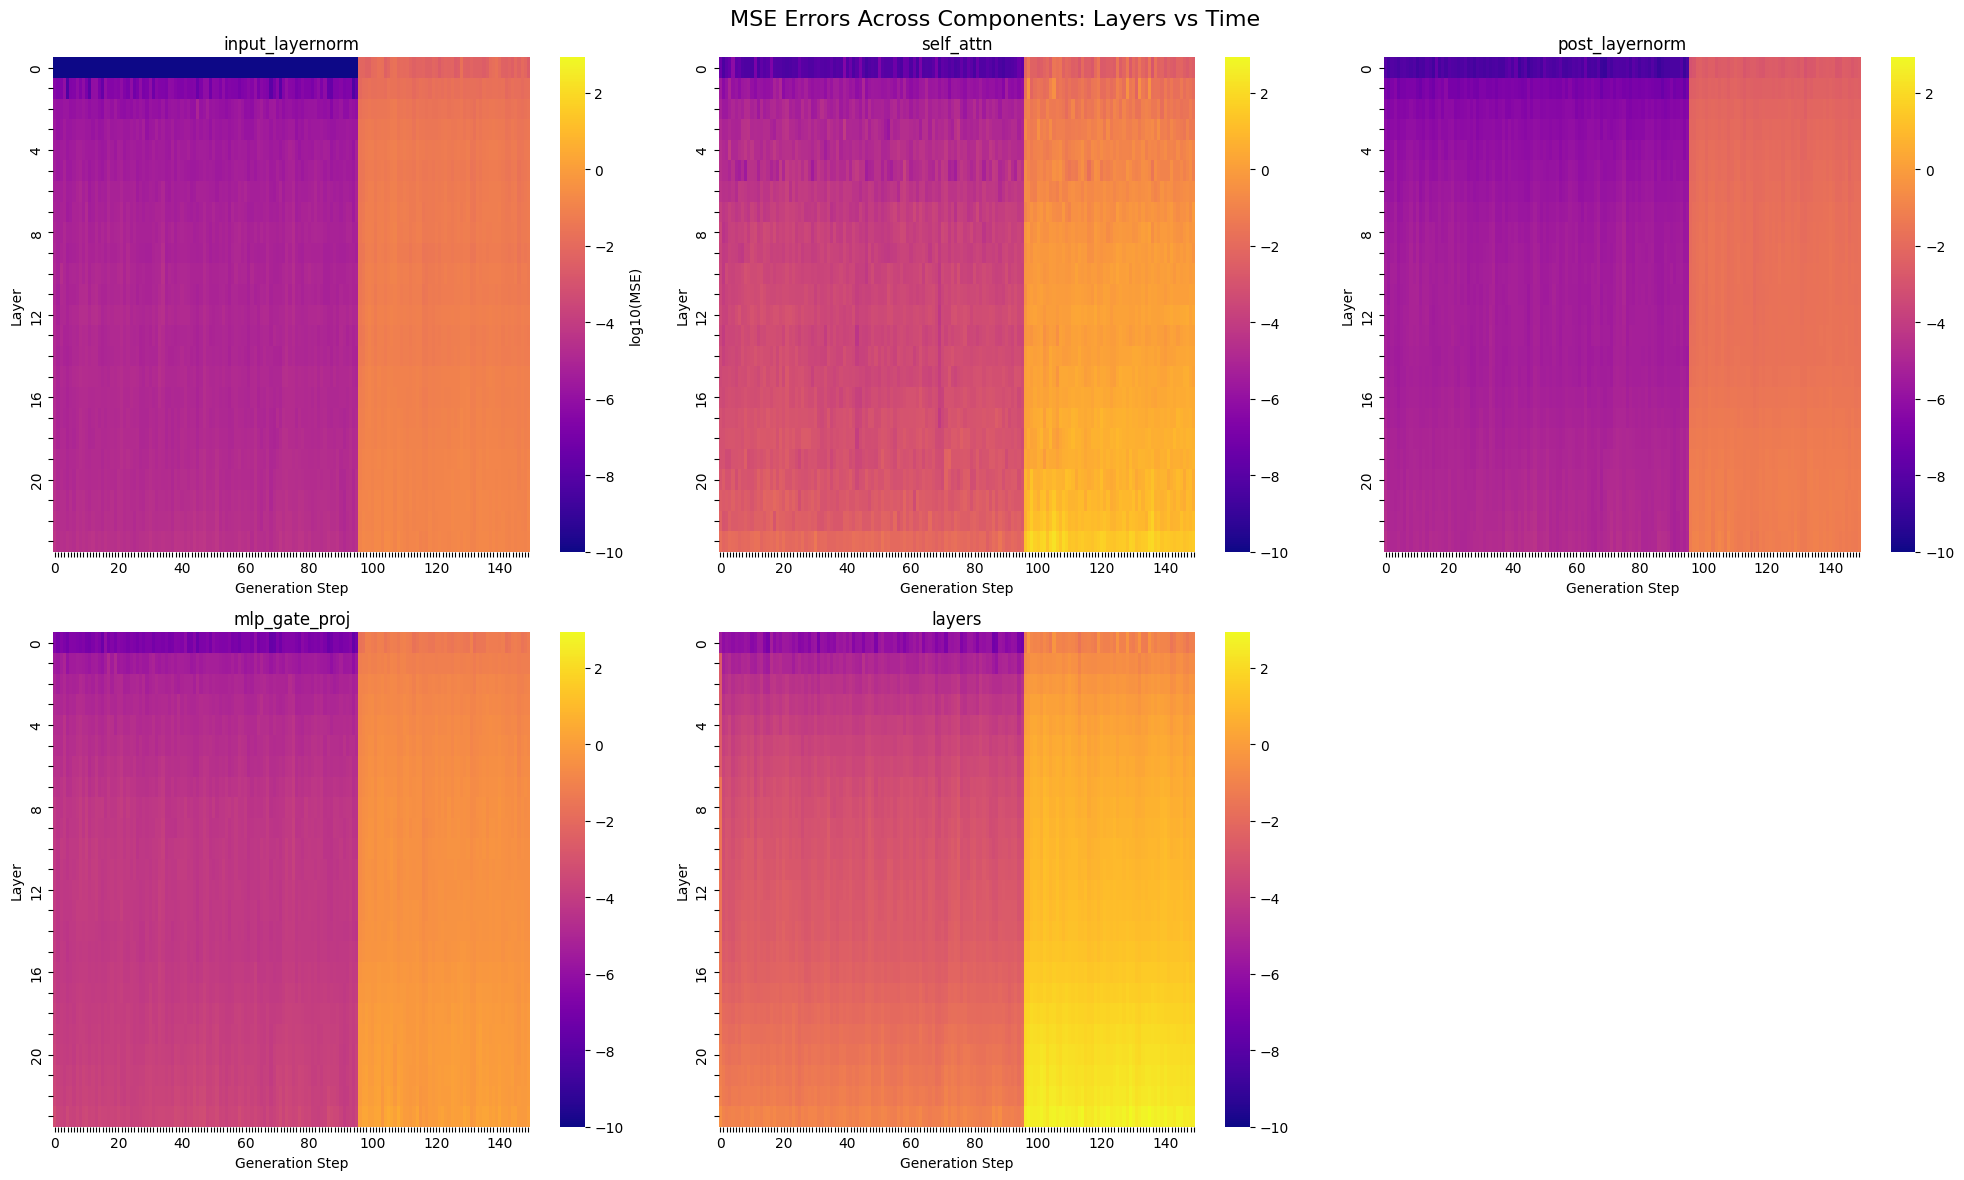

In [27]:
def visualize_layer_time_heatmap(error_type='layers', max_tokens=200, component='layers'):
    """
    Create a heatmap with layers on y-axis and time/tokens on x-axis
    
    Args:
        error_type: 'mse' or 'mae'
        max_tokens: Maximum number of tokens/time steps to show
        component: Which component to visualize ('layers', 'input_layernorm', 'self_attn', etc.)
    """
    layers = 24
    time_steps = min(max_tokens, 200)  # Adjust based on your data
    
    # Initialize error matrix: [layers, time_steps]
    error_matrix = np.zeros((layers, time_steps))
    
    for layer in range(layers):
        for t in range(time_steps):
            error_matrix[layer, t] = all_output[f"layers_d{layer}_i{t}"][0]
    
    # Create the heatmap
    plt.figure(figsize=(16, 10))
    
    # Use log scale for better visualization of small errors
    log_errors = np.log10(error_matrix + 1e-10)  # Add small value to avoid log(0)
    
    sns.heatmap(log_errors,
                cmap='viridis',
                cbar_kws={'label': f'log10({error_type.upper()} Error)'},
                xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(time_steps)],
                yticklabels=[f'Layer {i}' for i in range(layers)])
    
    plt.title(f'{error_type.upper()} Errors: {component} - Layers vs Generation Time')
    plt.xlabel('Generation Step (Token Index)')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()
    
    return error_matrix

def visualize_multiple_components_over_time(max_tokens=150):
    """
    Create multiple heatmaps for different components showing layer vs time
    with standardized color scale across all subplots
    """
    components = ['input_layernorm', 'self_attn', 'post_layernorm', 'mlp_gate_proj', 'layers']
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    
    # Collect all error matrices first to determine global min/max
    all_error_matrices = []
    
    for component in components:
        layers = 24
        time_steps = max_tokens
        error_matrix = np.zeros((layers, time_steps))
        
        for layer in range(layers):
            for t in range(time_steps):
                error_matrix[layer, t] = all_output[f"{component}_d{layer}_i{t}"][0]
        
        all_error_matrices.append(error_matrix)
    
    # Calculate global min and max for standardized scale
    all_log_errors = [np.log10(matrix + 1e-10) for matrix in all_error_matrices]
    global_vmin = min(matrix.min() for matrix in all_log_errors)
    global_vmax = max(matrix.max() for matrix in all_log_errors)
    
    print(f"Global log10 error range: [{global_vmin:.2f}, {global_vmax:.2f}]")
    
    # Create heatmaps with standardized scale
    for idx, (component, error_matrix) in enumerate(zip(components, all_error_matrices)):
        if idx >= len(axes):
            break
        
        log_errors = np.log10(error_matrix + 1e-10)
        
        sns.heatmap(log_errors,
                    cmap='plasma',
                    ax=axes[idx],
                    vmin=global_vmin,  # Standardized min
                    vmax=global_vmax,  # Standardized max
                    cbar_kws={'label': 'log10(MSE)'} if idx == 0 else {'label': ''},
                    xticklabels=[f'{i}' if i % 20 == 0 else '' for i in range(max_tokens)],
                    yticklabels=[f'{i}' if i % 4 == 0 else '' for i in range(24)])
        
        axes[idx].set_title(f'{component}')
        axes[idx].set_xlabel('Generation Step')
        axes[idx].set_ylabel('Layer')
    
    # Hide any unused subplots
    for idx in range(len(components), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('MSE Errors Across Components: Layers vs Time', fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
error_matrix = visualize_layer_time_heatmap('mse', max_tokens=150, component='layers')
visualize_multiple_components_over_time()